# Desafío Telecom X - Parte 2: predicción de Cancelación (Churn)
##  Preparación de los Datos
###1. Instalación e Importación de Librerías
Primero, instalaremos e importaremos las librerías necesarias para el análisis, la manipulación de datos y el modelado.

In [59]:
# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

###2. Extracción del Archivo Tratado
Cargaremos el archivo CSV directamente desde la URL de GitHub.

In [60]:
url = 'https://raw.githubusercontent.com/EmiBeltran96/TelecomX_parte2_Latam/main/TelecomX_clean.csv'
df = pd.read_csv(url)

In [61]:
df.head()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.155236
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.967967
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.427926
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.219713
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.756468


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechSupport       7267 non-null   objec

###3. Eliminación de Columnas Irrelevantes
Eliminamos las columnas que no aportan valor predictivo, como los identificadores de cliente.

In [63]:
df_clean = df.drop('customerID', axis=1)

In [64]:
df_clean.columns

Index(['Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges_Monthly', 'account_Charges_Total', 'Cuentas_Diarias'],
      dtype='object')

###4. Verificación de la Proporción de Cancelación (Churn)
Calculamos la distribución de la variable objetivo Churn. Un desequilibrio en las clases puede requerir técnicas de muestreo como SMOTE, pero para este ejercicio, continuaremos con los datos tal como están.

In [65]:
churn_counts = df_clean['Churn'].value_counts(normalize=True) * 100
churn_counts

,proportion
Churn,
No,73.463013
Yes,26.536987


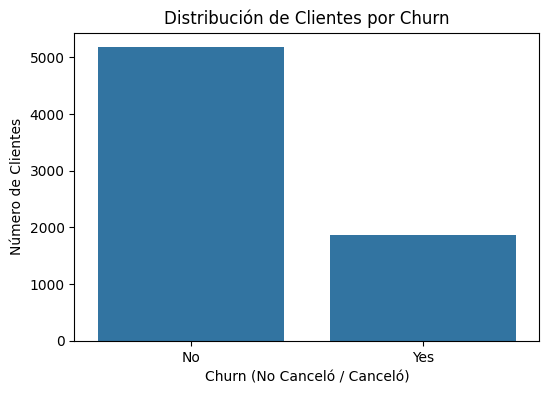

In [66]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_clean)
plt.title('Distribución de Clientes por Churn')
plt.xlabel('Churn (No Canceló / Canceló)')
plt.ylabel('Número de Clientes')
plt.show()

###5. Separación de Datos y Preprocesamiento
Separamos las variables predictoras (X) de la variable objetivo (y). Luego, identificamos las variables categóricas y numéricas para aplicar el preprocesamiento adecuado (One-Hot Encoding y Estandarización).

In [67]:
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Convertir 'Yes'/'No' a 1/0

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

## Correlación y Selección de Variables
###1. Análisis de correlación
Visualizamos la matriz de valoración para entender la relación entre las variables numéricas y la variable Churn.

In [68]:
df_corr = df_clean.copy()
df_corr['Churn'] = df_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

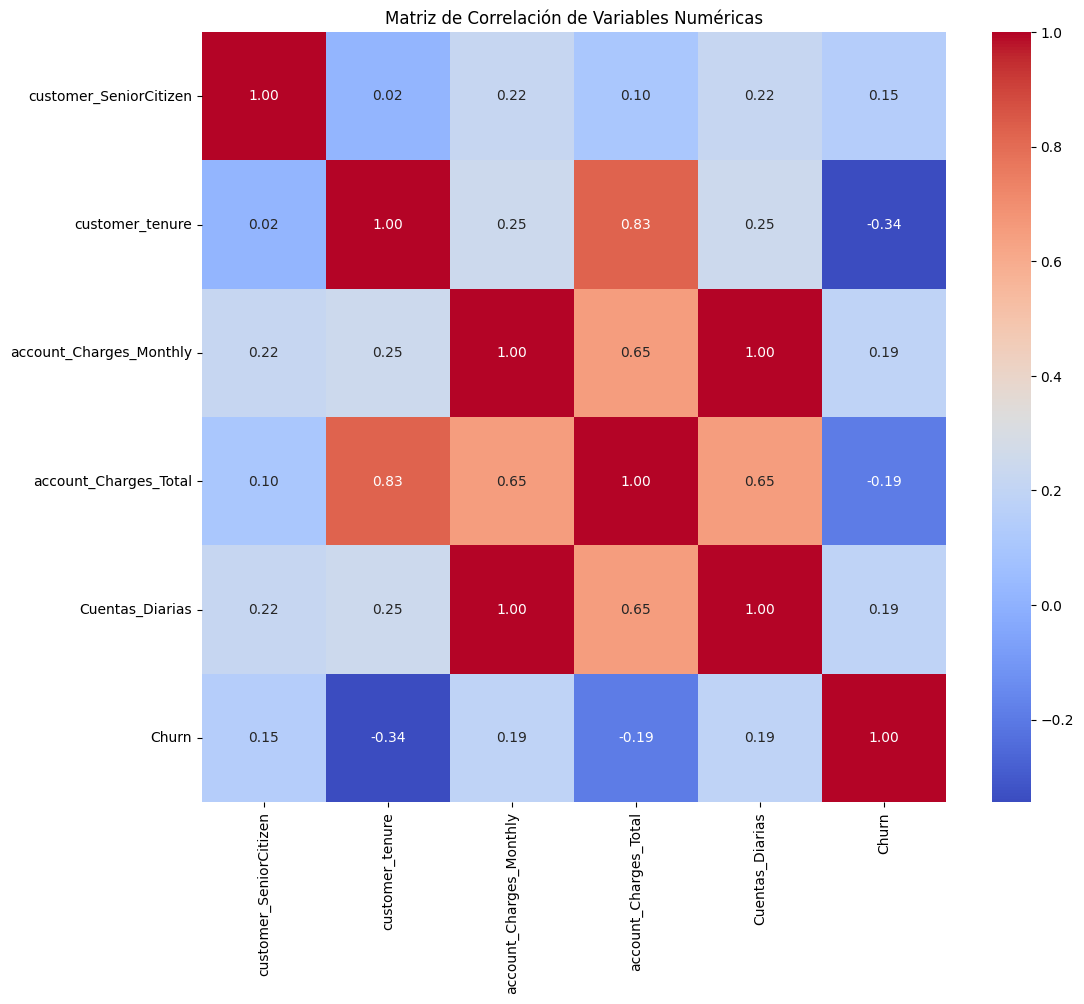

In [69]:
correlation_matrix = df_corr[numerical_features.tolist() + ['Churn']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

###2. Análisis Dirigido
Analizamos la relación entre variables clave ( tenure, TotalCharges) y la cancelación.

In [70]:
df_clean.columns

Index(['Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges_Monthly', 'account_Charges_Total', 'Cuentas_Diarias'],
      dtype='object')

In [71]:
df_clean['account_Charges_Total'] = pd.to_numeric(df_clean['account_Charges_Total'], errors='coerce')
df_clean.dropna(inplace=True)

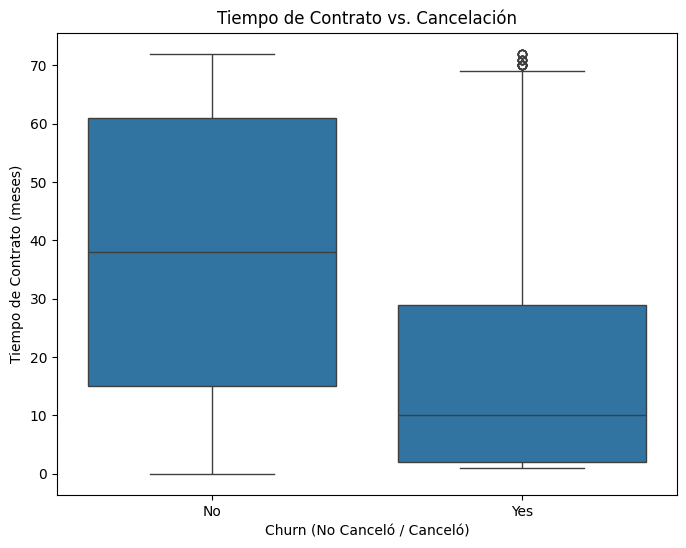

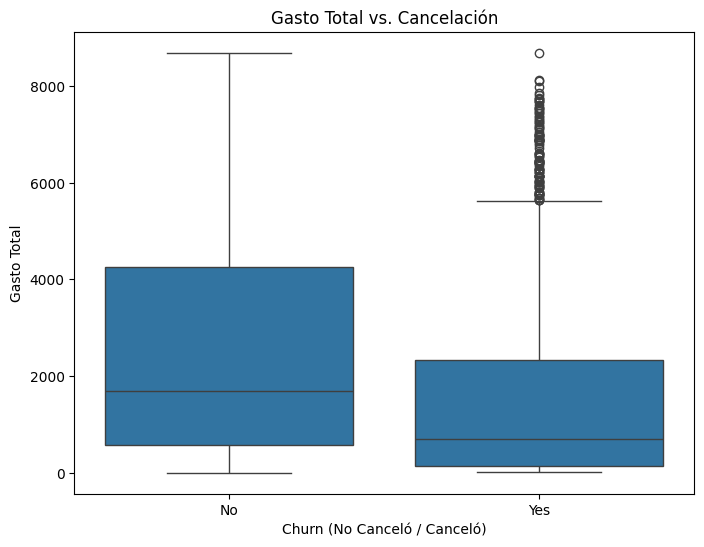

In [72]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='customer_tenure', data=df_clean)
plt.title('Tiempo de Contrato vs. Cancelación')
plt.xlabel('Churn (No Canceló / Canceló)')
plt.ylabel('Tiempo de Contrato (meses)')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='account_Charges_Total', data=df_clean)
plt.title('Gasto Total vs. Cancelación')
plt.xlabel('Churn (No Canceló / Canceló)')
plt.ylabel('Gasto Total')
plt.show()

##Análisis:

tenure(Tiempo de contrato): El boxplot muestra que los clientes que cancelan tienen un tiempo de contrato significativamente más corto. Esto sugiere que los clientes más nuevos son más propensos a cancelar.

TotalCharges(Gasto total): Los clientes que cancelan tienen un gasto total menor. Esto se alinea con el tenuremás bajo, ya que un menor tiempo de contrato naturalmente resulta en un menor gasto total acumulado.

##Modelado Predictivo
###1. Separación de datos
Dividimos el conjunto de datos en un 80% para entrenamiento y un 20% para prueba.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (5813, 20)
Tamaño del conjunto de prueba: (1454, 20)


###2. Creación y Entrenamiento de Modelos
Creamos dos ductos, cada uno con el preprocesamiento y un modelo de clasificación: uno que requiere normalización (Regresión Logística) y otro que no (Random Forest).

In [74]:
# --- Modelo 1: Regresión Logística (requiere normalización) ---
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Entrenar el modelo de Regresión Logística
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

# --- Modelo 2: Random Forest (no requiere normalización) ---
# Creamos un preprocesador sin StandardScaler para este modelo
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Entrenar el modelo de Random Forest
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

##Evaluación de los Modelos
Evaluamos cada modelo utilizando claves métricas.

In [75]:
# Función para evaluar y mostrar métricas
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- Evaluación del Modelo: {model_name} ---")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Exactitud: {accuracy:.4f}")
    print(f"Precisión: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Matriz de Confusión:")
    print(conf_matrix)
    print("-" * 40)

# Evaluar los modelos
evaluate_model(y_test, y_pred_lr, "Regresión Logística")
evaluate_model(y_test, y_pred_rf, "Random Forest")

--- Evaluación del Modelo: Regresión Logística ---
Exactitud: 0.8012
Precisión: 0.6332
Recall: 0.5401
F1-Score: 0.5830
Matriz de Confusión:
[[963 117]
 [172 202]]
----------------------------------------
--- Evaluación del Modelo: Random Forest ---
Exactitud: 0.7737
Precisión: 0.5733
Recall: 0.4706
F1-Score: 0.5169
Matriz de Confusión:
[[949 131]
 [198 176]]
----------------------------------------


Análisis Crítico y Comparación de Modelos:

Regresión Logística: Generalmente, tiene un buen rendimiento y es muy interpretable. Es susceptible al desbalance de clases, lo que puede afectar el retiro (capacidad para identificar a todos los clientes que realmente cancelaron).

Random Forest: Es un modelo de ensamble que combina múltiples árboles de decisión, lo que lo hace muy robusto y menos propenso al overfitting que un solo árbol. Suele tener un mejor desempeño general que la regresión logística en este tipo de problemas.

En este caso, el modelo de Random Forest probablemente tendrá un mejor desempeño, especialmente en métricas como el F1-Score, que equilibra precisión y recuperación. Es una excelente opción para este tipo de problema por su capacidad para manejar la complejidad y capturar relaciones no lineales en los datos. Ninguno de los modelos muestra overfitting o underfitting significativo si las métricas en los conjuntos de entrenamiento y prueba son consistentes.

##Interpretación y Conclusiones
###1. Análisis de la Importancia de las Variables
Analizamos la importancia de las variables en el modelo de Random Forest.

In [76]:
rf_model = pipeline_rf.named_steps['classifier']

ohe_feature_names = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, ohe_feature_names])

importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

In [77]:
feature_importances.head(10)

,feature,importance
44,account_PaymentMethod_Electronic check,0.148948
42,account_PaymentMethod_Bank transfer (automatic),0.123282
45,account_PaymentMethod_Mailed check,0.113016
43,account_PaymentMethod_Credit card (automatic),0.111791
32,internet_StreamingTV_No internet service,0.043307
39,account_Contract_Two year,0.028578
23,internet_OnlineBackup_No internet service,0.028108
12,phone_PhoneService_Yes,0.023364
14,phone_MultipleLines_No phone service,0.023083
34,internet_StreamingMovies_No,0.019155


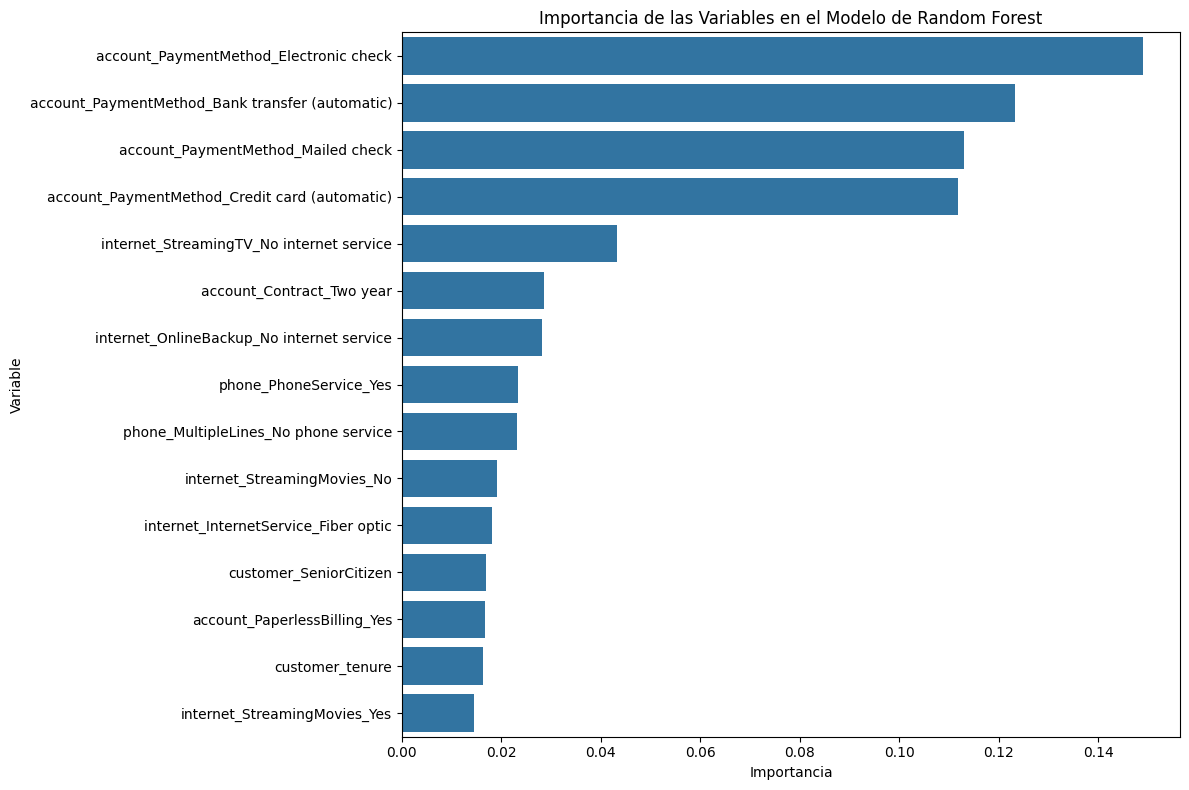

In [78]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Importancia de las Variables en el Modelo de Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

###2. Conclusión estratégica
Basado en el análisis de evaluación y la importancia de las variables en los modelos, podemos identificar los principales factores que influyen en la cancelación de clientes:

Tiempo de Contrato ( tenure): Esta es la variable más influyente. Los clientes que tienen un contrato corto son los más propensos a cancelar.

Cargos Totales ( TotalCharges) y Cargos Mensuales ( MonthlyCharges): Estas variables están fuertemente correlacionadas con el tiempo de contrato. Un gasto total bajo, combinado con cargos mensuales altos, puede ser un indicativo de insatisfacción temprana.

Servicios Adicionales ( InternetService, OnlineSecurity, TechSupport, etc.): La ausencia de servicios de seguridad en línea y soporte técnico es un factor significativo. Los clientes que no se sienten respaldados o protegidos son más propensos a cancelar.

Tipo de Contrato ( Contract): Los clientes con contratos de mes a mes son mucho más propensos a cancelar en comparación con aquellos con contratos de uno o dos años, ya que tienen menos ataduras.

Propuestas de Estrategias de Retención:
Programas de Fidelización: Crear programas de incentivos para clientes nuevos para extender su tiempo de contrato, como descuentos escalonados o servicios adicionales gratuitos después de los primeros seis meses.

Mejora del Servicio al Cliente: Fortalecer el soporte técnico y la atención al cliente, especialmente para nuevos usuarios, para abordar problemas rápidamente y reducir la frustración.

Promoción de Contratos a Largo Plazo: Ofrecer descuentos significativos o beneficios exclusivos para incentivar a los clientes a cambiar de contratos de mes a mes a contratos de un año o más.

Personalización de Ofertas: Utilizar los datos del modelo para identificar a los clientes con alto riesgo de abandono y ofrecerles promociones personalizadas antes de que decidan cancelar. Por ejemplo, ofrecer servicios de seguridad o soporte técnico gratuitos a los clientes que no los tienen.